In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from keras.layers import Input, Dense, Dropout
from keras.models import Model
from keras.optimizers import Adam, RMSprop
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from keras.initializers import glorot_normal

In [2]:
df_all = pd.read_csv("../../dataset/2022.06.12.csv") # label 섞여 있는 데이터셋
df_true = pd.read_csv("../../dataset/2021.01.01.csv") # label=benign 데이터셋

pd.DataFrame(df_all)

,avg_ipt,bytes_in,bytes_out,dest_ip,dest_port,entropy,num_pkts_out,num_pkts_in,proto,src_ip,src_port,time_end,time_start,total_entropy,label,duration
0,0.0,0,0,786,31306.0,0.000000,1,0,6,786,47613.0,1655074782132491,1655074782132491,0.000000,outlier,0.000000
1,0.0,0,0,786,24298.0,0.000000,1,0,6,786,47613.0,1655074782573321,1655074782573321,0.000000,outlier,0.000000
2,0.0,0,0,786,31789.0,0.000000,1,0,6,786,47613.0,1655074783148517,1655074783148517,0.000000,outlier,0.000000
3,0.0,0,0,786,29409.0,0.000000,1,0,6,786,47613.0,1655074783149855,1655074783149855,0.000000,outlier,0.000000
4,0.0,0,0,786,60965.0,0.000000,1,0,6,786,47613.0,1655074783167254,1655074783167254,0.000000,outlier,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26162,0.0,0,0,786,554.0,0.000000,2,1,6,786,8492.0,1655078343916062,1655078343822522,0.000000,outlier,0.093540
26163,0.0,8,8,786,NaN,3.000000,1,1,1,786,NaN,1655078338259086,1655078338258995,47.999996,outlier,0.000091
26164,0.0,8,8,786,NaN,3.000000,1,1,1,786,NaN,165507834136686,165507834136681,47.999996,outlier,0.000050
26165,93.0,0,23,786,554.0,3.914866,4,3,6,786,49872.0,1655078344174555,1655078343989254,90.041930,outlier,0.185301


In [3]:
pd.DataFrame(df_true)

,avg_ipt,bytes_in,bytes_out,dest_ip,dest_port,entropy,num_pkts_out,num_pkts_in,proto,src_ip,src_port,time_end,time_start,total_entropy,label,duration
0,2716.142857,969,10051,786,9200,3.093910,7,7,6,786,56328,160946769170627,1609467672690358,34094.88700,benign,19.015911
1,1901.400000,967,23531,786,9200,1.642038,10,7,6,786,56324,1609467691706011,1609467672689065,40226.65200,benign,19.016947
2,907.312500,754,32742,786,9092,1.111004,32,20,6,786,57148,1609467701725488,1609467672683006,37214.20000,benign,29.042482
3,549.842105,588,13833,786,9300,2.344926,57,34,6,786,56998,1609467713462009,1609467682094405,33816.18400,benign,31.367603
4,4288.714286,0,224,15169,53,3.326140,7,0,17,786,46151,1609467715620521,1609467685597113,745.05536,benign,30.023409
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43773,728.090909,721,52541,786,9200,0.791238,11,6,6,786,56318,160954557746121,1609545569450156,42142.94500,benign,8.011054
43774,2.000000,326,10147,786,9200,2.675070,4,2,6,786,56324,160954556945598,1609545569447221,28016.00400,benign,0.008759
43775,0.000000,0,0,15169,53,0.000000,4,0,6,786,50018,1609545585432444,1609545578304481,0.00000,benign,7.127963
43776,0.500000,457,1370,786,9300,5.862206,2,1,6,786,59370,1609545586890016,1609545586888719,10710.24900,benign,0.001297


In [4]:
X_train = df_true # 학습 데이터로 normal 데이터만을 취급한다.
X_test, X_val = train_test_split(df_all, test_size=0.3, random_state=42)
# test, validation은 abnormal +

X_train.shape, X_test.shape, X_val.shape

((43778, 16), (18316, 16), (7851, 16))

Text(0, 0.5, 'frequency')

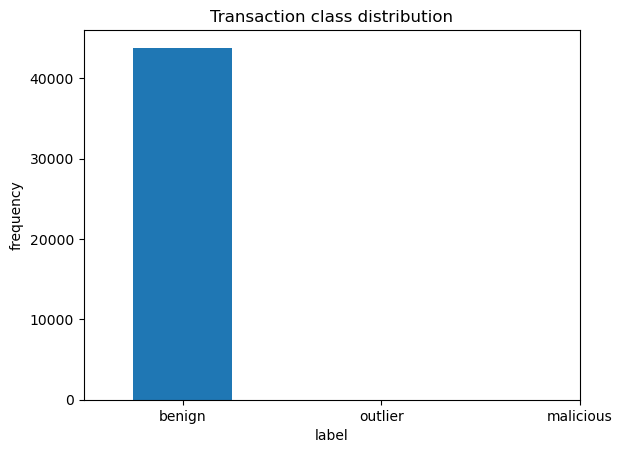

In [5]:
LABELS = ['benign', 'outlier', 'malicious']

count_classes = pd.value_counts(X_train['label'], sort=True)
count_classes.plot(kind='bar', rot=0)
plt.title('Transaction class distribution')
plt.xticks(range(3), LABELS)
plt.xlabel('label')
plt.ylabel('frequency')

([<matplotlib.axis.XTick at 0x7f9e5f4549d0>,
 [Text(0, 0, 'benign'), Text(1, 0, 'outlier'), Text(2, 0, 'malicious')])

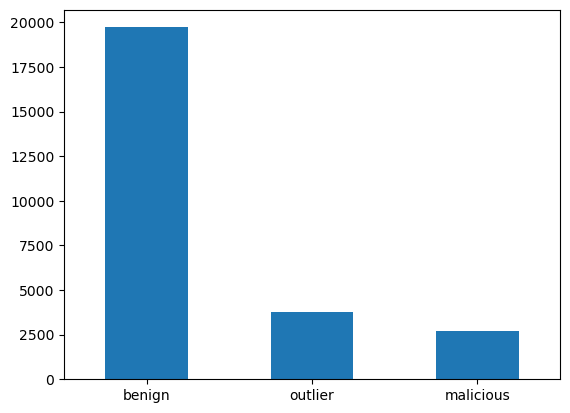

In [6]:
count_classes_all = pd.value_counts(df_all['label'], sort=True)
count_classes_all.plot(kind='bar', rot=0)
plt.xticks(range(3), LABELS)

In [7]:
pd.DataFrame(X_train)

,avg_ipt,bytes_in,bytes_out,dest_ip,dest_port,entropy,num_pkts_out,num_pkts_in,proto,src_ip,src_port,time_end,time_start,total_entropy,label,duration
0,2716.142857,969,10051,786,9200,3.093910,7,7,6,786,56328,160946769170627,1609467672690358,34094.88700,benign,19.015911
1,1901.400000,967,23531,786,9200,1.642038,10,7,6,786,56324,1609467691706011,1609467672689065,40226.65200,benign,19.016947
2,907.312500,754,32742,786,9092,1.111004,32,20,6,786,57148,1609467701725488,1609467672683006,37214.20000,benign,29.042482
3,549.842105,588,13833,786,9300,2.344926,57,34,6,786,56998,1609467713462009,1609467682094405,33816.18400,benign,31.367603
4,4288.714286,0,224,15169,53,3.326140,7,0,17,786,46151,1609467715620521,1609467685597113,745.05536,benign,30.023409
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43773,728.090909,721,52541,786,9200,0.791238,11,6,6,786,56318,160954557746121,1609545569450156,42142.94500,benign,8.011054
43774,2.000000,326,10147,786,9200,2.675070,4,2,6,786,56324,160954556945598,1609545569447221,28016.00400,benign,0.008759
43775,0.000000,0,0,15169,53,0.000000,4,0,6,786,50018,1609545585432444,1609545578304481,0.00000,benign,7.127963
43776,0.500000,457,1370,786,9300,5.862206,2,1,6,786,59370,1609545586890016,1609545586888719,10710.24900,benign,0.001297


In [8]:
y_test = X_test['label']

X_train = pd.DataFrame(X_train).drop(['label'], axis=1)
X_test = pd.DataFrame(X_test).drop(['label'], axis=1)
X_val = pd.DataFrame(X_val).drop(['label'], axis=1)

X_train = X_train.values
X_test = X_test.values
X_val = X_val.values

In [9]:
pd.DataFrame(X_train)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,2716.142857,969.0,10051.0,786.0,9200.0,3.093910,7.0,7.0,6.0,786.0,56328.0,1.609468e+14,1.609468e+15,34094.88700,19.015911
1,1901.400000,967.0,23531.0,786.0,9200.0,1.642038,10.0,7.0,6.0,786.0,56324.0,1.609468e+15,1.609468e+15,40226.65200,19.016947
2,907.312500,754.0,32742.0,786.0,9092.0,1.111004,32.0,20.0,6.0,786.0,57148.0,1.609468e+15,1.609468e+15,37214.20000,29.042482
3,549.842105,588.0,13833.0,786.0,9300.0,2.344926,57.0,34.0,6.0,786.0,56998.0,1.609468e+15,1.609468e+15,33816.18400,31.367603
4,4288.714286,0.0,224.0,15169.0,53.0,3.326140,7.0,0.0,17.0,786.0,46151.0,1.609468e+15,1.609468e+15,745.05536,30.023409
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43773,728.090909,721.0,52541.0,786.0,9200.0,0.791238,11.0,6.0,6.0,786.0,56318.0,1.609546e+14,1.609546e+15,42142.94500,8.011054
43774,2.000000,326.0,10147.0,786.0,9200.0,2.675070,4.0,2.0,6.0,786.0,56324.0,1.609546e+14,1.609546e+15,28016.00400,0.008759
43775,0.000000,0.0,0.0,15169.0,53.0,0.000000,4.0,0.0,6.0,786.0,50018.0,1.609546e+15,1.609546e+15,0.00000,7.127963
43776,0.500000,457.0,1370.0,786.0,9300.0,5.862206,2.0,1.0,6.0,786.0,59370.0,1.609546e+15,1.609546e+15,10710.24900,0.001297


In [10]:
scaler = MinMaxScaler()

X_train = scaler.fit_transform(X_train)
X_val = scaler.fit_transform(X_val)
X_test = scaler.fit_transform(X_test)

X_train.shape, X_test.shape, X_val.shape

((43778, 15), (18316, 15), (7851, 15))

In [11]:
NUM_COL = 15

In [12]:
learning_rate = 0.00001
batch_size = 512
epochs = 100
adam = Adam(learning_rate=learning_rate, beta_1=0.5)

In [13]:
from keras.models import Sequential
from keras.initializers import Initializer
from keras.layers import Activation
from tqdm import tqdm

In [14]:
def get_generator(optimizer):
    generator = Sequential()
    generator.add(Dense(64, input_dim=NUM_COL, kernel_initializer=glorot_normal(seed=42)))
    generator.add(Activation('tanh'))

    generator.add(Dense(128))
    generator.add(Activation('tanh'))

    generator.add(Dense(256))
    generator.add(Activation('tanh'))

    generator.add(Dense(512))
    generator.add(Activation('tanh'))

    generator.add(Dense(NUM_COL, activation='tanh'))

    generator.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0002, beta_1=0.5))

    return generator

In [15]:
def get_discriminator(optimizer):
    discriminator = Sequential()
    
    discriminator.add(Dense(256, input_dim=NUM_COL, kernel_initializer=glorot_normal(seed=42)))
    discriminator.add(Activation('relu'))
    discriminator.add(Dropout(0.2))

    discriminator.add(Dense(128))
    discriminator.add(Activation('relu'))
    discriminator.add(Dropout(0.2))

    discriminator.add(Dense(128))
    discriminator.add(Activation('relu'))
    discriminator.add(Dropout(0.2))

    discriminator.add(Dense(128))
    discriminator.add(Activation('relu'))
    discriminator.add(Dropout(0.2))

    discriminator.add(Dense(1))
    discriminator.add(Activation('sigmoid'))

    discriminator.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0002, beta_1=0.5))

    return discriminator

In [16]:
def get_gan_network(discriminator, generator, optimizer, input_dim=NUM_COL):
    discriminator.trainable = False
    gan_input = Input(shape=(input_dim, ))
    x = generator(gan_input)
    gan_output = discriminator(x)

    gan = Model(inputs=gan_input, outputs=gan_output)
    gan.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0002, beta_1=0.5))

    return gan

In [17]:
batch_count = X_train.shape[0] // batch_size
pbar = tqdm(total=epochs*batch_count)
gan_loss = []
discriminator_loss = []

generator = get_generator(adam)
discriminator = get_discriminator(adam)
gan = get_gan_network(
    discriminator=discriminator, 
    generator=generator, 
    optimizer=adam,
    input_dim=NUM_COL
)

for epoch in range(epochs):
    for index in range(batch_count):
        pbar.update(1)

        noise = np.random.normal(0, 1, size=[batch_size, NUM_COL])
        generated_images = generator.predict_on_batch(noise)

        image_batch = X_train[index * batch_size: (index + 1) * batch_size]

        X = np.vstack((generated_images, image_batch))
        y_dis = np.ones(2 * batch_size)
        y_dis[:batch_size] = 0

        discriminator.trainable = True
        d_loss = discriminator.train_on_batch(X, y_dis)

        noise = np.random.uniform(0, 1, size=[batch_size, NUM_COL])
        y_gen = np.ones(batch_size)
        discriminator.trainable = False
        g_loss = gan.train_on_batch(noise, y_gen)

        discriminator_loss.append(d_loss)
        gan_loss.append(g_loss)

    print("Epoch %d Batch %d/%d [D loss: %f] [G loss: %f]" % (epoch, index, batch_count, d_loss, g_loss))

  0%|          | 0/8500 [00:00<?, ?it/s]/Users/kimtaeyoon/opt/anaconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
  1%|          | 90/8500 [00:03<04:23, 31.97it/s] 

Epoch 0 Batch 84/85 [D loss: 0.456684] [G loss: 0.375346]


  2%|▏         | 174/8500 [00:06<04:26, 31.20it/s]

Epoch 1 Batch 84/85 [D loss: 0.323174] [G loss: 0.372495]


  3%|▎         | 262/8500 [00:08<03:47, 36.22it/s]

Epoch 2 Batch 84/85 [D loss: 0.237525] [G loss: 0.833035]


  4%|▍         | 346/8500 [00:11<03:37, 37.45it/s]

Epoch 3 Batch 84/85 [D loss: 0.134843] [G loss: 2.484294]


  5%|▌         | 430/8500 [00:13<03:34, 37.69it/s]

Epoch 4 Batch 84/85 [D loss: 0.161582] [G loss: 0.463402]


  6%|▌         | 518/8500 [00:15<03:33, 37.38it/s]

Epoch 5 Batch 84/85 [D loss: 0.145041] [G loss: 0.710920]


  7%|▋         | 602/8500 [00:17<03:30, 37.53it/s]

Epoch 6 Batch 84/85 [D loss: 0.107404] [G loss: 1.565257]


  8%|▊         | 686/8500 [00:20<03:28, 37.47it/s]

Epoch 7 Batch 84/85 [D loss: 0.064019] [G loss: 0.937016]


  9%|▉         | 770/8500 [00:22<03:25, 37.53it/s]

Epoch 8 Batch 84/85 [D loss: 0.071349] [G loss: 1.198909]


 10%|█         | 858/8500 [00:24<03:26, 36.99it/s]

Epoch 9 Batch 84/85 [D loss: 0.060089] [G loss: 1.079839]


 11%|█         | 942/8500 [00:27<03:27, 36.39it/s]

Epoch 10 Batch 84/85 [D loss: 0.062972] [G loss: 1.418348]


 12%|█▏        | 1026/8500 [00:29<03:19, 37.48it/s]

Epoch 11 Batch 84/85 [D loss: 0.052098] [G loss: 0.708984]


 13%|█▎        | 1110/8500 [00:31<03:16, 37.63it/s]

Epoch 12 Batch 84/85 [D loss: 0.044567] [G loss: 1.345184]


 14%|█▍        | 1198/8500 [00:34<03:14, 37.52it/s]

Epoch 13 Batch 84/85 [D loss: 0.043850] [G loss: 1.176223]


 15%|█▌        | 1282/8500 [00:36<03:12, 37.56it/s]

Epoch 14 Batch 84/85 [D loss: 0.052516] [G loss: 0.918398]


 16%|█▌        | 1366/8500 [00:38<03:11, 37.19it/s]

Epoch 15 Batch 84/85 [D loss: 0.059303] [G loss: 1.225178]


 17%|█▋        | 1450/8500 [00:40<03:06, 37.76it/s]

Epoch 16 Batch 84/85 [D loss: 0.057014] [G loss: 1.960082]


 18%|█▊        | 1538/8500 [00:43<03:04, 37.67it/s]

Epoch 17 Batch 84/85 [D loss: 0.040655] [G loss: 1.742845]


 19%|█▉        | 1622/8500 [00:45<03:02, 37.64it/s]

Epoch 18 Batch 84/85 [D loss: 0.044077] [G loss: 1.537925]


 20%|██        | 1706/8500 [00:47<03:00, 37.71it/s]

Epoch 19 Batch 84/85 [D loss: 0.050211] [G loss: 1.484285]


 21%|██        | 1790/8500 [00:49<02:58, 37.66it/s]

Epoch 20 Batch 84/85 [D loss: 0.059376] [G loss: 1.986210]


 22%|██▏       | 1878/8500 [00:52<02:56, 37.61it/s]

Epoch 21 Batch 84/85 [D loss: 0.040083] [G loss: 2.894483]


 23%|██▎       | 1962/8500 [00:54<02:53, 37.73it/s]

Epoch 22 Batch 84/85 [D loss: 0.052847] [G loss: 2.273379]


 24%|██▍       | 2046/8500 [00:56<02:57, 36.46it/s]

Epoch 23 Batch 84/85 [D loss: 0.045289] [G loss: 2.772847]


 25%|██▌       | 2130/8500 [00:59<02:49, 37.61it/s]

Epoch 24 Batch 84/85 [D loss: 0.035476] [G loss: 2.953842]


 26%|██▌       | 2218/8500 [01:01<02:46, 37.72it/s]

Epoch 25 Batch 84/85 [D loss: 0.040937] [G loss: 2.740392]


 27%|██▋       | 2302/8500 [01:03<02:44, 37.65it/s]

Epoch 26 Batch 84/85 [D loss: 0.043192] [G loss: 2.387776]


 28%|██▊       | 2386/8500 [01:05<02:42, 37.58it/s]

Epoch 27 Batch 84/85 [D loss: 0.069421] [G loss: 2.897140]


 29%|██▉       | 2470/8500 [01:08<02:47, 36.10it/s]

Epoch 28 Batch 84/85 [D loss: 0.069775] [G loss: 2.231673]


 30%|███       | 2558/8500 [01:10<02:37, 37.71it/s]

Epoch 29 Batch 84/85 [D loss: 0.057096] [G loss: 1.813646]


 31%|███       | 2642/8500 [01:12<02:36, 37.50it/s]

Epoch 30 Batch 84/85 [D loss: 0.049995] [G loss: 1.733347]


 32%|███▏      | 2726/8500 [01:15<02:35, 37.16it/s]

Epoch 31 Batch 84/85 [D loss: 0.053227] [G loss: 1.520522]


 33%|███▎      | 2810/8500 [01:17<02:31, 37.61it/s]

Epoch 32 Batch 84/85 [D loss: 0.039660] [G loss: 1.810447]


 34%|███▍      | 2898/8500 [01:19<02:29, 37.42it/s]

Epoch 33 Batch 84/85 [D loss: 0.040186] [G loss: 2.833332]


 35%|███▌      | 2982/8500 [01:21<02:27, 37.51it/s]

Epoch 34 Batch 84/85 [D loss: 0.057660] [G loss: 1.816047]


 36%|███▌      | 3066/8500 [01:24<02:26, 37.09it/s]

Epoch 35 Batch 84/85 [D loss: 0.044775] [G loss: 2.351741]


 37%|███▋      | 3150/8500 [01:26<02:22, 37.58it/s]

Epoch 36 Batch 84/85 [D loss: 0.052757] [G loss: 1.961373]


 38%|███▊      | 3238/8500 [01:28<02:20, 37.47it/s]

Epoch 37 Batch 84/85 [D loss: 0.067252] [G loss: 3.273689]


 39%|███▉      | 3322/8500 [01:31<02:17, 37.61it/s]

Epoch 38 Batch 84/85 [D loss: 0.062489] [G loss: 2.362960]


 40%|████      | 3406/8500 [01:33<02:15, 37.52it/s]

Epoch 39 Batch 84/85 [D loss: 0.038726] [G loss: 2.510058]


 41%|████      | 3490/8500 [01:35<02:13, 37.63it/s]

Epoch 40 Batch 84/85 [D loss: 0.042136] [G loss: 2.345921]


 42%|████▏     | 3578/8500 [01:37<02:10, 37.65it/s]

Epoch 41 Batch 84/85 [D loss: 0.076666] [G loss: 3.983410]


 43%|████▎     | 3662/8500 [01:40<02:16, 35.51it/s]

Epoch 42 Batch 84/85 [D loss: 0.048773] [G loss: 1.705835]


 44%|████▍     | 3746/8500 [01:42<02:06, 37.50it/s]

Epoch 43 Batch 84/85 [D loss: 0.055808] [G loss: 3.082373]


 45%|████▌     | 3830/8500 [01:44<02:05, 37.30it/s]

Epoch 44 Batch 84/85 [D loss: 0.053760] [G loss: 3.547221]


 46%|████▌     | 3918/8500 [01:47<02:02, 37.26it/s]

Epoch 45 Batch 84/85 [D loss: 0.041642] [G loss: 3.600898]


 47%|████▋     | 4002/8500 [01:49<01:59, 37.64it/s]

Epoch 46 Batch 84/85 [D loss: 0.059438] [G loss: 2.370914]


 48%|████▊     | 4086/8500 [01:51<01:57, 37.57it/s]

Epoch 47 Batch 84/85 [D loss: 0.034157] [G loss: 3.223439]


 49%|████▉     | 4170/8500 [01:53<01:55, 37.55it/s]

Epoch 48 Batch 84/85 [D loss: 0.049726] [G loss: 3.314681]


 50%|█████     | 4258/8500 [01:56<01:52, 37.57it/s]

Epoch 49 Batch 84/85 [D loss: 0.044188] [G loss: 2.144079]


 51%|█████     | 4342/8500 [01:58<01:57, 35.49it/s]

Epoch 50 Batch 84/85 [D loss: 0.052603] [G loss: 2.486185]


 52%|█████▏    | 4426/8500 [02:00<01:47, 37.74it/s]

Epoch 51 Batch 84/85 [D loss: 0.021451] [G loss: 3.110190]


 53%|█████▎    | 4510/8500 [02:03<01:45, 37.88it/s]

Epoch 52 Batch 84/85 [D loss: 0.042619] [G loss: 3.694579]


 54%|█████▍    | 4598/8500 [02:05<01:44, 37.45it/s]

Epoch 53 Batch 84/85 [D loss: 0.092808] [G loss: 3.146307]


 55%|█████▌    | 4682/8500 [02:07<01:42, 37.35it/s]

Epoch 54 Batch 84/85 [D loss: 0.043033] [G loss: 3.512417]


 56%|█████▌    | 4766/8500 [02:09<01:43, 36.10it/s]

Epoch 55 Batch 84/85 [D loss: 0.060968] [G loss: 2.886999]


 57%|█████▋    | 4850/8500 [02:12<01:37, 37.43it/s]

Epoch 56 Batch 84/85 [D loss: 0.077308] [G loss: 2.007581]


 58%|█████▊    | 4938/8500 [02:14<01:34, 37.70it/s]

Epoch 57 Batch 84/85 [D loss: 0.047233] [G loss: 4.425227]


 59%|█████▉    | 5022/8500 [02:16<01:34, 36.74it/s]

Epoch 58 Batch 84/85 [D loss: 0.051576] [G loss: 5.003593]


 60%|██████    | 5106/8500 [02:19<01:30, 37.65it/s]

Epoch 59 Batch 84/85 [D loss: 0.060952] [G loss: 3.719893]


 61%|██████    | 5190/8500 [02:21<01:28, 37.52it/s]

Epoch 60 Batch 84/85 [D loss: 0.117256] [G loss: 3.777093]


 62%|██████▏   | 5278/8500 [02:23<01:25, 37.54it/s]

Epoch 61 Batch 84/85 [D loss: 0.060562] [G loss: 3.124270]


 63%|██████▎   | 5362/8500 [02:26<01:23, 37.49it/s]

Epoch 62 Batch 84/85 [D loss: 0.034051] [G loss: 3.452734]


 64%|██████▍   | 5446/8500 [02:28<01:22, 36.82it/s]

Epoch 63 Batch 84/85 [D loss: 0.032458] [G loss: 3.729489]


 65%|██████▌   | 5530/8500 [02:30<01:19, 37.53it/s]

Epoch 64 Batch 84/85 [D loss: 0.025119] [G loss: 3.184566]


 66%|██████▌   | 5618/8500 [02:32<01:16, 37.55it/s]

Epoch 65 Batch 84/85 [D loss: 0.039518] [G loss: 4.834535]


 67%|██████▋   | 5702/8500 [02:35<01:14, 37.65it/s]

Epoch 66 Batch 84/85 [D loss: 0.018184] [G loss: 4.008453]


 68%|██████▊   | 5786/8500 [02:37<01:12, 37.52it/s]

Epoch 67 Batch 84/85 [D loss: 0.076157] [G loss: 2.894700]


 69%|██████▉   | 5870/8500 [02:39<01:10, 37.46it/s]

Epoch 68 Batch 84/85 [D loss: 0.053664] [G loss: 3.330724]


 70%|███████   | 5958/8500 [02:42<01:07, 37.66it/s]

Epoch 69 Batch 84/85 [D loss: 0.101512] [G loss: 3.491044]


 71%|███████   | 6042/8500 [02:44<01:05, 37.71it/s]

Epoch 70 Batch 84/85 [D loss: 0.038132] [G loss: 3.681525]


 72%|███████▏  | 6126/8500 [02:46<01:03, 37.62it/s]

Epoch 71 Batch 84/85 [D loss: 0.021215] [G loss: 2.780161]


 73%|███████▎  | 6210/8500 [02:48<01:01, 37.43it/s]

Epoch 72 Batch 84/85 [D loss: 0.059743] [G loss: 4.755614]


 74%|███████▍  | 6294/8500 [02:51<00:58, 37.59it/s]

Epoch 73 Batch 84/85 [D loss: 0.045259] [G loss: 2.114249]


 75%|███████▌  | 6382/8500 [02:53<00:56, 37.34it/s]

Epoch 74 Batch 84/85 [D loss: 0.021493] [G loss: 4.407150]


 76%|███████▌  | 6466/8500 [02:55<00:54, 37.48it/s]

Epoch 75 Batch 84/85 [D loss: 0.020064] [G loss: 4.764878]


 77%|███████▋  | 6550/8500 [02:58<00:52, 37.40it/s]

Epoch 76 Batch 84/85 [D loss: 0.049751] [G loss: 5.834278]


 78%|███████▊  | 6638/8500 [03:00<00:49, 37.66it/s]

Epoch 77 Batch 84/85 [D loss: 0.037950] [G loss: 3.993013]


 79%|███████▉  | 6722/8500 [03:02<00:47, 37.51it/s]

Epoch 78 Batch 84/85 [D loss: 0.017333] [G loss: 3.132737]


 80%|████████  | 6806/8500 [03:04<00:45, 37.25it/s]

Epoch 79 Batch 84/85 [D loss: 0.075032] [G loss: 2.732957]


 81%|████████  | 6890/8500 [03:07<00:42, 37.58it/s]

Epoch 80 Batch 84/85 [D loss: 0.048679] [G loss: 3.668554]


 82%|████████▏ | 6978/8500 [03:09<00:41, 37.08it/s]

Epoch 81 Batch 84/85 [D loss: 0.010079] [G loss: 4.155263]


 83%|████████▎ | 7062/8500 [03:11<00:38, 37.20it/s]

Epoch 82 Batch 84/85 [D loss: 0.066391] [G loss: 2.747804]


 84%|████████▍ | 7146/8500 [03:14<00:36, 37.40it/s]

Epoch 83 Batch 84/85 [D loss: 0.041059] [G loss: 3.386553]


 85%|████████▌ | 7230/8500 [03:16<00:34, 37.24it/s]

Epoch 84 Batch 84/85 [D loss: 0.043437] [G loss: 3.952444]


 86%|████████▌ | 7318/8500 [03:18<00:31, 37.31it/s]

Epoch 85 Batch 84/85 [D loss: 0.026346] [G loss: 4.604275]


 87%|████████▋ | 7402/8500 [03:21<00:29, 36.61it/s]

Epoch 86 Batch 84/85 [D loss: 0.032266] [G loss: 3.215007]


 88%|████████▊ | 7486/8500 [03:23<00:27, 36.83it/s]

Epoch 87 Batch 84/85 [D loss: 0.064296] [G loss: 2.543089]


 89%|████████▉ | 7570/8500 [03:25<00:25, 37.04it/s]

Epoch 88 Batch 84/85 [D loss: 0.031210] [G loss: 4.394328]


 90%|█████████ | 7658/8500 [03:28<00:22, 37.07it/s]

Epoch 89 Batch 84/85 [D loss: 0.015138] [G loss: 3.132440]


 91%|█████████ | 7742/8500 [03:30<00:20, 37.05it/s]

Epoch 90 Batch 84/85 [D loss: 0.033912] [G loss: 4.060833]


 92%|█████████▏| 7826/8500 [03:32<00:18, 37.13it/s]

Epoch 91 Batch 84/85 [D loss: 0.102520] [G loss: 4.979374]


 93%|█████████▎| 7910/8500 [03:34<00:15, 36.99it/s]

Epoch 92 Batch 84/85 [D loss: 0.116647] [G loss: 4.464880]


 94%|█████████▍| 7998/8500 [03:37<00:13, 37.19it/s]

Epoch 93 Batch 84/85 [D loss: 0.043992] [G loss: 3.087238]


 95%|█████████▌| 8082/8500 [03:39<00:11, 36.67it/s]

Epoch 94 Batch 84/85 [D loss: 0.015740] [G loss: 3.865746]


 96%|█████████▌| 8166/8500 [03:41<00:09, 36.77it/s]

Epoch 95 Batch 84/85 [D loss: 0.035118] [G loss: 2.907734]


 97%|█████████▋| 8250/8500 [03:44<00:06, 36.92it/s]

Epoch 96 Batch 84/85 [D loss: 0.045855] [G loss: 4.226213]


 98%|█████████▊| 8338/8500 [03:46<00:04, 36.86it/s]

Epoch 97 Batch 84/85 [D loss: 0.021546] [G loss: 4.874538]


 99%|█████████▉| 8422/8500 [03:48<00:02, 37.00it/s]

Epoch 98 Batch 84/85 [D loss: 0.011725] [G loss: 4.322096]


100%|█████████▉| 8498/8500 [03:51<00:00, 35.65it/s]

Epoch 99 Batch 84/85 [D loss: 0.009879] [G loss: 4.627438]


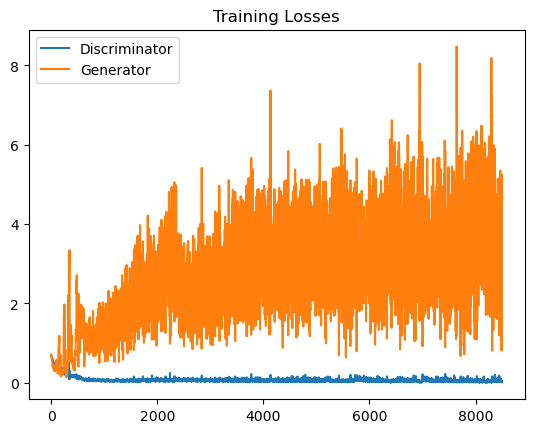

In [18]:
fig, ax = plt.subplots()
plt.plot(discriminator_loss, label='Discriminator')
plt.plot(gan_loss, label='Generator')
plt.title('Training Losses')
plt.legend()

In [19]:
# Predictions on the test set

nr_batches_test = np.ceil(X_test.shape[0] // batch_size).astype(np.int32)

results =[]

for t in range(nr_batches_test +1):    
        ran_from = t * batch_size
        ran_to = (t + 1) * batch_size
        image_batch = X_test[ran_from:ran_to]             
        tmp_rslt = discriminator.predict(x=image_batch,batch_size=128,verbose=0)        
        results = np.append(results, tmp_rslt)   

In [20]:
results

array([ 1., nan,  1., ...,  1., nan,  1.])

In [21]:
y2 = y_test.to_numpy()

In [22]:
pd.options.display.float_format = '{:20,.7f}'.format
results_df = pd.concat([pd.DataFrame(results),pd.DataFrame(y2)], axis=1)
results_df.columns = ['results','y_test']
print ('Mean score for Normal data :', results_df.loc[results_df['y_test'] == 1, 'results'].mean() )
print ('Mean score for Fall data :', results_df.loc[results_df['y_test'] == 0, 'results'].mean())

Mean score for Normal data : nan
Mean score for Fall data : nan


In [23]:
#Obtaining the lowest 1% score
per = np.percentile(results,1)
y_pred = results.copy()
y_pred = np.array(y_pred)

#Thresholding based on the score
inds = (y_pred > per)
inds_comp = (y_pred <= per)
y_pred[inds] = 0
y_pred[inds_comp] = 1
precision, recall, f1,_ = precision_recall_fscore_support(y_test,y_pred,average='binary')
print ('Accuracy Score :',accuracy_score(y_test, y_pred) )
print ('Precision :',precision )
print ('Recall :',recall )
print ('F1 :',f1 )

NameError: name 'precision_recall_fscore_support' is not defined

100%|██████████| 8500/8500 [04:10<00:00, 35.65it/s]

In [ ]:
cm = confusion_matrix(y_test, y_pred)

print ('Confusion Matrix :')

def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Greens):
    plt.figure(figsize=(10,10),)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    plt.tight_layout()

    width, height = cm.shape

    for x in range(width):
        for y in range(height):
            plt.annotate(str(cm[x][y]), xy=(y, x), 
                        horizontalalignment='center',
                        verticalalignment='center')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


plot_confusion_matrix(cm)

In [ ]:
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_pred)
auc_keras = auc(fpr_keras, tpr_keras)
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.2f})'.format(auc_keras))

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()